# MO436C — Introduction to Self-Supervised (Representation) Learning (SSRL)

**Yan Prada Moro and Giovanne Mariano**  
*Universidade Estadual de Campinas — Campinas, Brazil*  
*November 22, 2025*

---

### Masked Autoencoders (MAE) — Hands-On Tutorial

In this hands-on session, we explore a complete **Self-Supervised Representation Learning (SSRL)** pipeline, moving from **pretraining** with a reconstruction-based objective to **downstream supervised fine-tuning**. Our pretext task is **masked image reconstruction**, a scalable method that enables Vision Transformers (ViTs) to learn expressive and transferable representations from unlabeled images.

---

### 1. Overview of Masked Autoencoders

Masked Autoencoders (MAE) learn visual representations by reconstructing heavily masked images. Inspired by masked language modeling, MAE applies random masking (commonly **75%**) to image patches and trains the model to reconstruct missing content.

<img src="https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="600" alt="MAE diagram">

#### Asymmetric architecture

**Encoder (ViT)**  
- Processes only **visible (unmasked)** patches.  
- Does **not** receive mask tokens.  
- Learns compact, semantically rich representations.  
- Efficient due to shorter sequence length.

**Decoder**  
- Lightweight and shallow.  
- Receives:
  - Encoder representations for visible patches  
  - Learnable mask tokens for missing patches  
- Reconstructs **all** patches at the pixel level.

This design allows MAEs to scale effectively, enabling large encoders while keeping computation manageable.

---

### 2. Dataset and Motivation

We use the **STL-10** dataset:

- **10 classes**: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck  
- **Labeled training**: 5,000 images (500 per class)  
- **Test**: 8,000 images  
- **Unlabeled**: 100,000 images (broader distribution)  
- Resolution: **96 × 96 RGB**

STL-10 is ideal for studying SSRL because it provides a **large unlabeled pool** and **restricted labeled regimes**, allowing us to evaluate how representation quality scales with unlabeled data.

---

### 3. Pretraining Setup (MAE)

We pretrained MAE encoder–decoder models on subsets of the unlabeled set: **25%**, **50%**, **75%**, and **100%**. Each subset was used to train an MAE **from scratch** (independent runs).

#### Architectural specification
- Patch size: **8 × 8**  
- **Encoder**
  - Embedding dim: **144**
  - Depth: **4**
  - Attention heads: **6**
- **Decoder**
  - Embedding dim: **192**
  - Depth: **2**
  - Attention heads: **6**
- Masking ratio: **0.75**  
- Loss: **MSE** on normalized pixel patches

#### Training details
- **800 epochs** (pretraining)  
- Optimizer: **AdamW**  
- Base LR: **1.5×10⁻⁴** with cosine decay  
- Batch size: **2000**  
- Weight decay: **0.05**  
- Warmup: **20 epochs**  
- Augmentation: **RandomResizedCrop only** (kept minimal to isolate unlabeled-data effects)

Each MAE checkpoint (25/50/75/100% unlabeled) is used for downstream fine-tuning experiments.

---

### 4. Downstream Task: STL-10 Classification

We evaluate pretrained encoders on labeled subsets of sizes:

**10, 25, 50, 100, 200, 300, 400 examples per class**

#### Progressive fine-tuning schedule (4 stages)
1. **Frozen encoder** — train only classification head. (LR: **3×10⁻⁴**)  
2. **Unfreeze last encoder layer** — joint train head + last layer. (LR: **1×10⁻⁴**)  
3. **Unfreeze last two encoder layers**. (LR: **5×10⁻⁵**)  
4. **Full end-to-end fine-tuning**. (LR: **5×10⁻⁵**)

> **Rationale:** progressive unfreezing preserves pretrained features and reduces catastrophic forgetting when labeled data are scarce.

#### Supervised baseline
- Train same ViT architecture from scratch (no SSL).  
- **200 epochs**, LR **1×10⁻⁴**.  
- Baseline is not compute-matched (SSL includes pretraining), but it serves to contextualize benefits of pretraining.

> **Observation:** In this notebook we focus on importing pretrained models and visualizing results in downstram test set. For full training code, please refer to the [GitHub repository](https://github.com/giolucasd/ssrl-vit-mae-jepa).
---

### Summary <a class="anchor" id="topo"></a>

* [Part 1: Project setup](#part_01).
* [Part 2: Implementing Masked Autoencoders Model](#part_02).
* [Part 3: Implementing Vision Classifier](#part_03).
* [Part 4: Building a MAE training module](#part_04).
* [Part 5: Building a downstream task training module](#part_05).
* [Part 6: Constructing STL10 dataloaders](#part_06).
* [Part 7: Self-supervised pretraining with MAE](#part_07)
* [Part 8: Visualizing some reconstructed images](#part_08).
* [Part 9: Fine-tuning the downstream task (image classification)](#part_09).
* [Part 10: Evaluating the downstream task](#part_10).
* [Part 11: Visualizing UMAP class representations](#part_11).

### Part 1: Project setup <a class="anchor" id="part_01"></a>

Here we load the main libraries that will be used throughout this notebook. We also set some configuration parameters for torch reproducibility and filter warnings. 

Finally, we download the pretrained weights that will be used in the downstream task.


In [1]:
import os

# Set the environment variable to silence the tip
os.environ['LIT_MODELS_V0_CLOUD_CHECK'] = '0' 

import logging
import math
import re
import warnings
from typing import Any, Dict, Optional, Tuple
import numpy as np
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
import torch
import torch.nn.functional as F
from lightly.models import utils
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from timm.models.vision_transformer import VisionTransformer
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Subset, random_split
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from torchvision.datasets import STL10
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "data"
WEIGHTS_DIR = ROOT_DIR / "assets" / "weights"
BEST_PRETRAIN_MODEL_PATH = WEIGHTS_DIR / "vit-mae.pt"
BEST_CLASSIF_MODEL_PATH = WEIGHTS_DIR / "mae_100_400.pt"


warnings.filterwarnings(
    "ignore",
    "Precision bf16-mixed is not supported by the model summary",
)

warnings.filterwarnings(
    "ignore",
    "Please use the new API settings to control TF32 behavior",
)

logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

pl.seed_everything(seed=73, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision("medium")

Seed set to 73


In [3]:
cfg = {
    "model": {
        "general": {
            "image_size": 96,
            "patch_size": 8,
            "in_chans": 3,
        },
        "encoder": {
            "embed_dim": 144,
            "depth": 4,
            "num_heads": 6,
        },
        "decoder": {
            "decoder_embed_dim": 192,
            "decoder_depth": 2,
            "decoder_num_heads": 6,
        },
        "head": {
            "embed_dim": 144,
            "pool": "cls",
        },
    },
    "pretrain": {
        "mask_ratio_start": 0.75,
        "mask_ratio_end": 0.75,
        "mask_ramp_epochs": 5,
        "total_epochs": 10,
        "warmup_epochs": 20,
        "batch_size": 512,
        "base_learning_rate": 1.5e-4,
        "weight_decay": 0.05,
        "data_fraction": 1.00,
        "val_split": 0.06,
        "num_workers": 4,
    },
    "train": {
        "samples_per_class": 400,
        "total_epochs": 50,
        "warmup_epochs": 10,
        "batch_size": 512,
        "learning_rate": 1e-4,
        "weight_decay": 0.05,
        "freeze_encoder": True,
        "num_workers": 4,
    },
    "test": {
        "batch_size": 512,
        "num_workers": 4,
    },
    "logging": {
        "output_dir_base": "outputs",
        "model_path": "vit-mae.pt",
    },
}

In [4]:
# Download pretrained weights
no_checkpoint = not BEST_CLASSIF_MODEL_PATH.exists() or not BEST_PRETRAIN_MODEL_PATH.exists()
if no_checkpoint:
    !bash download_weights.sh

--2025-11-24 11:07:25--  https://github.com/giolucasd/ssrl-vit-mae-jepa/releases/download/v1.0/mae_classifier_weights_v1.zip
Resolving github.com (github.com)... 4.228.31.150
Connecting to github.com (github.com)|4.228.31.150|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/1089068822/738ce888-bc6e-4e9f-ab9d-6335fad9d10c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-24T14%3A59%3A38Z&rscd=attachment%3B+filename%3Dmae_classifier_weights_v1.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-24T13%3A59%3A26Z&ske=2025-11-24T14%3A59%3A38Z&sks=b&skv=2018-11-09&sig=AkL0ELzFttvnVEBXiRomtU%2FPuO2lu3KQFazcXSYW8VM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2Mzk5Njg0NSwibmJmIjoxNzYzOTkzMjQ1LCJwYXRoI

### Part 2: Implementing Masked Autoencoders Model<a class="anchor" id="part_02"></a>
In this part, we will implement the Masked Autoencoder (MAE) model using PyTorch. The MAE consists of an encoder and a decoder, where the encoder processes only the visible patches of the input image, and the decoder reconstructs the full image from the encoded representation and mask tokens.

In [4]:
class MaskedAutoencoder(nn.Module):
    """Masked Autoencoder (MAE) with ViT backbone."""

    def __init__(
        self,
        general_cfg: Dict[str, Any],
        encoder_cfg: Dict[str, Any],
        decoder_cfg: Dict[str, Any],
    ):
        super().__init__()

        self.mask_ratio = general_cfg.get("mask_ratio", 0.75)
        self.image_size = general_cfg.get("image_size", 96)
        self.patch_size = general_cfg.get("patch_size", 6)
        self.in_chans = general_cfg.get("in_chans", 3)

        vit = VisionTransformer(
            img_size=self.image_size,
            patch_size=self.patch_size,
            in_chans=self.in_chans,
            embed_dim=encoder_cfg.get("embed_dim", 384),
            depth=encoder_cfg.get("depth", 12),
            num_heads=encoder_cfg.get("num_heads", 6),
            num_classes=0,
        )

        self.encoder = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = getattr(
            self.encoder,
            "sequence_length",
            vit.patch_embed.num_patches + 1,
        )

        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches,
            patch_size=self.patch_size,
            embed_dim=encoder_cfg.get("embed_dim", 384),
            decoder_embed_dim=decoder_cfg.get("decoder_embed_dim", 512),
            decoder_depth=decoder_cfg.get("decoder_depth", 4),
            decoder_num_heads=decoder_cfg.get("decoder_num_heads", 6),
        )

    def forward_encoder(self, images: torch.Tensor, idx_keep=None):
        return self.encoder.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)

        x_masked = utils.repeat_token(
            token=self.decoder.mask_token,
            size=(batch_size, self.sequence_length),
        )
        x_masked = utils.set_at_index(
            tokens=x_masked,
            index=idx_keep,
            value=x_decode.type_as(x_masked),
        )

        x_decoded = self.decoder.decode(x_masked)
        x_pred = utils.get_at_index(tokens=x_decoded, index=idx_mask)
        x_pred = self.decoder.predict(x_pred)

        return x_pred

    def forward(self, images: torch.Tensor):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )

        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )

        patches = utils.patchify(images=images, patch_size=self.patch_size)
        idx_mask_adj = torch.clamp(idx_mask - 1, min=0)
        target = utils.get_at_index(tokens=patches, index=idx_mask_adj)

        return x_pred, target

### Part 3: Implementing Vision Classifier<a class="anchor" id="part_03"></a>
In this part, we will implement a Vision Classifier using PyTorch. The classifier will take the encoded representations from the MAE as input and output class predictions for the downstream task, which in this case is the classification of images with the SLT-10 dataset.

In [5]:
class ViTClassifier(nn.Module):
    """Classifier built on top of a pretrained ViT encoder."""

    def __init__(
        self,
        pretrained_encoder: VisionTransformer,
        num_classes: int = 10,
        head_cfg: Optional[Dict[str, Any]] = None,
    ):
        super().__init__()
        self.encoder = pretrained_encoder
        head_cfg = head_cfg or {}

        embed_dim = head_cfg.get("embed_dim", pretrained_encoder.embed_dim)
        pool_type = head_cfg.get("pool", "cls")  # or "mean"

        self.pool_type = pool_type
        self.head = SimpleHead(
            input_dim=embed_dim,
            output_dim=num_classes,
        )

    def forward(self, x: torch.Tensor):
        feats = self.encoder.forward_features(x)
        if isinstance(feats, (tuple, list)):
            feats = feats[0]

        if self.pool_type == "cls":
            pooled = feats[:, 0]
        else:
            pooled = feats.mean(dim=1)

        return self.head(pooled)

class SimpleHead(torch.nn.Module):
    """Simple classification head."""

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
    ) -> None:
        super().__init__()
        self.classification = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classification(x)

### Part 4: Building a MAE training module<a class="anchor" id="part_04"></a>
In this part, we will build a training module for the Masked Autoencoder (MAE) model using PyTorch Lightning. This module will handle the training loop, validation, and optimization of the MAE model.

In [6]:
class MAEPretrainModule(pl.LightningModule):
    """Self-supervised pretraining for Masked Autoencoder."""

    def __init__(
        self,
        model_cfg: Dict[str, Any],
        training_cfg: Dict[str, Any],
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = MaskedAutoencoder(
            general_cfg=model_cfg["general"],
            encoder_cfg=model_cfg["encoder"],
            decoder_cfg=model_cfg["decoder"],
        )

        self.mask_start = training_cfg.get("mask_ratio_start", 0.5)
        self.mask_end = training_cfg.get("mask_ratio_end", 0.85)
        self.ramp_epochs = training_cfg.get("mask_ramp_epochs", 200)

        self.lr = float(training_cfg.get("base_learning_rate", 1.5e-4))
        self.weight_decay = float(training_cfg.get("weight_decay", 0.05))
        self.warmup_epochs = int(training_cfg.get("warmup_epochs", 20))
        self.total_epochs = int(training_cfg.get("total_epochs", 200))
        self.batch_size = int(training_cfg.get("batch_size", 512))
        self.criterion = torch.nn.MSELoss()

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        preds, targets = self(imgs)
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        preds, targets = self(imgs)
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        effective_lr = self.lr * self.batch_size / 256
        optimizer = AdamW(
            self.parameters(),
            lr=effective_lr,
            weight_decay=self.weight_decay,
        )

        def lr_lambda(epoch):
            warmup = (epoch + 1) / max(1, self.warmup_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * epoch / self.total_epochs))
            return min(warmup, 1.0) * cosine

        scheduler = LambdaLR(optimizer, lr_lambda)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "epoch", "name": "lr"},
        }

    def on_train_epoch_start(self):
        """Update mask ratio linearly over epochs."""
        progress = min(self.current_epoch / max(1, self.ramp_epochs - 1), 1.0)
        new_mask = self.mask_start + progress * (self.mask_end - self.mask_start)
        self.model.mask_ratio = new_mask
        self.log("mask_ratio", new_mask, prog_bar=True)

### Part 5: Building a downstream task training module<a class="anchor" id="part_05"></a>
In this part, we will build a training module for the downstream vision classification task using PyTorch Lightning. This module will handle the training loop, validation, and optimization of the vision classifier model.

In [7]:
class ViTClassifierTrainModule(pl.LightningModule):
    """
    Supervised training for ViTClassifier.

    Supports randomly initialized or pretrained ViT encoder.
    Provides both fine-tuning and linear probing.
    """

    def __init__(
        self,
        pretrained_encoder: Optional[torch.nn.Module] = None,
        model_cfg: Optional[Dict[str, Any]] = None,
        training_cfg: Optional[Dict[str, Any]] = None,
        num_classes: int = 10,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["pretrained_encoder"])

        self.model_cfg = model_cfg or {}
        self.training_cfg = training_cfg or {}

        self.learning_rate = float(training_cfg.get("learning_rate", 3e-4))
        self.weight_decay = float(training_cfg.get("weight_decay", 0.05))
        self.warmup_epochs = int(training_cfg.get("warmup_epochs", 5))
        self.total_epochs = int(training_cfg.get("total_epochs", 100))
        self.freeze_encoder_flag = self.training_cfg.get("freeze_encoder", True)
        self.num_classes = num_classes

        # Build model
        encoder_cfg = self.model_cfg.get("encoder", {})
        encoder = (
            pretrained_encoder
            if pretrained_encoder is not None
            else VisionTransformer(
                img_size=self.model_cfg["general"]["image_size"],
                patch_size=self.model_cfg["general"]["patch_size"],
                in_chans=self.model_cfg["general"]["in_chans"],
                embed_dim=encoder_cfg.get("embed_dim", 384),
                depth=encoder_cfg.get("depth", 12),
                num_heads=encoder_cfg.get("num_heads", 6),
                num_classes=0,
            )
        )

        self.model = ViTClassifier(
            pretrained_encoder=encoder,
            num_classes=self.num_classes,
            head_cfg=self.model_cfg.get("head", {}),
        )

        # Freeze or unfreeze encoder as requested
        if self.freeze_encoder_flag:
            self.freeze_encoder()
        else:
            self.unfreeze_encoder()

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

        def lr_lambda(epoch):
            warmup = (epoch + 1) / max(1, self.warmup_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * epoch / self.total_epochs))
            return min(warmup, 1.0) * cosine

        scheduler = LambdaLR(optimizer, lr_lambda)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_loss",
            },
        }

    def freeze_encoder(self):
        for name, param in self.model.named_parameters():
            if "head" not in name:
                param.requires_grad = False
        print("🧊 Encoder frozen (only classifier head is trainable).")

    def unfreeze_encoder(self):
        for param in self.model.parameters():
            param.requires_grad = True
        print("🔥 Encoder unfrozen (all parameters trainable).")

    def unfreeze_last_layers(self, n_layers: int):
        """
        Unfreezes only the last `n_layers` Transformer blocks of the ViT encoder.
        All earlier layers remain frozen.
        """
        encoder = self.model.encoder  # timm VisionTransformer
        blocks = encoder.blocks  # list of Transformer blocks
        total = len(blocks)

        if n_layers < 0 or n_layers > total:
            raise ValueError(f"n_layers must be between 0 and {total}, got {n_layers}")

        print(f"🔓 Unfreezing last {n_layers} of {total} encoder layers...")

        # 1) Freeze ALL parameters first
        for param in encoder.parameters():
            param.requires_grad = False

        # 2) Unfreeze the last N Transformer blocks
        for block in blocks[total - n_layers :]:
            for param in block.parameters():
                param.requires_grad = True

        # 3) Also unfreeze the final LN (norm) layer
        if hasattr(encoder, "norm"):
            for param in encoder.norm.parameters():
                param.requires_grad = True

        # 4) Head (classifier) is always trainable
        for param in self.model.head.parameters():
            param.requires_grad = True

        print("🔥 Selective unfreezing complete.")

### Part 6: Constructing STL10 dataloaders<a class="anchor" id="part_06"></a>
In this part, we will construct the dataloaders for both the self-supervised pretraining task (MAE) and the downstream supervised task (vision classification). We will use the STL-10 dataset for both tasks, applying appropriate transformations for each.

In [8]:
def _build_transform(train: bool = True) -> transforms.Compose:
    """Standard STL-10 augmentations."""
    if train:
        return transforms.Compose(
            [
                transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    else:
        return transforms.Compose(
            [
                transforms.Resize(96),
                transforms.CenterCrop(96),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )


def _subset_dataset(dataset, fraction: float) -> Subset | STL10:
    """Optionally take a fraction of a dataset."""
    if fraction < 1.0:
        n = int(len(dataset) * fraction)
        return Subset(dataset, range(n))
    return dataset


def get_pretrain_dataloaders(cfg: dict) -> tuple[DataLoader, DataLoader]:
    """
    Builds train/val dataloaders for self-supervised pretraining (unlabeled split).

    Args:
        cfg (dict): configuration dictionary with keys:
            - batch_size (int)
            - val_split (float)
            - data_fraction (float)
            - seed (int)
            - num_workers (int)
    """
    pre_cfg = cfg["pretrain"]
    seed = cfg.get("seed", 73)

    full_dataset = STL10(
        DATA_DIR,
        split="unlabeled",
        transform=_build_transform(train=True),
        download=True,
    )

    # Optionally subsample dataset
    full_dataset = _subset_dataset(full_dataset, pre_cfg.get("data_fraction", 1.0))

    # Split into train/val subsets
    n_total = len(full_dataset)
    val_split = pre_cfg.get("val_split", 0.1)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val

    train_subset, val_subset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed),
    )
    val_subset.dataset.transform = _build_transform(train=False)

    batch_size = pre_cfg.get("batch_size", 512)
    num_workers = pre_cfg.get("num_workers", 4)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(
        f"📦 Unlabeled pretrain split: {n_train} train, {n_val} val "
        f"({val_split * 100:.1f}% validation)"
    )

    return train_loader, val_loader


def get_train_dataloaders(cfg: dict) -> tuple[DataLoader, DataLoader]:
    """
    Builds train/val dataloaders for fine-tuning on labeled STL-10 split.
    The training set is sampled with `samples_per_class`, and the remaining
    labeled data becomes the validation set.

    Args:
        cfg (dict): configuration dictionary with keys:
            - batch_size (int)
            - samples_per_class (int)
            - seed (int)
            - num_workers (int)
    """
    train_cfg = cfg["train"]
    seed = cfg.get("seed", 73)

    full_dataset = STL10(DATA_DIR, split="train", transform=_build_transform(True))
    labels = np.array(full_dataset.labels)

    samples_per_class = train_cfg.get("samples_per_class", 400)
    train_indices, val_indices = [], []

    for c in np.unique(labels):
        cls_idx = np.where(labels == c)[0]
        np.random.default_rng(seed).shuffle(cls_idx)
        train_indices.extend(cls_idx[:samples_per_class])
        val_indices.extend(cls_idx[samples_per_class:])

    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    val_dataset.dataset.transform = _build_transform(train=False)

    print(
        f"⚙️ Using {samples_per_class} samples/class → {len(train_indices)} train, "
        f"{len(val_indices)} val"
    )

    batch_size = train_cfg.get("batch_size", 256)
    num_workers = train_cfg.get("num_workers", 4)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader


def get_test_dataloader(cfg: dict) -> DataLoader:
    """Returns only the STL-10 test split for final evaluation."""
    test_cfg = cfg.get("test", {})
    batch_size = test_cfg.get("batch_size", 256)
    num_workers = test_cfg.get("num_workers", 4)

    test_dataset = STL10(DATA_DIR, split="test", transform=_build_transform(False))

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(f"🧪 Loaded STL-10 test split: {len(test_dataset)} samples")

    return test_loader


### Part 7: Self-supervised pretraining with MAE<a class="anchor" id="part_07"></a>
In this part, we will perform self-supervised pretraining of the Masked Autoencoder (MAE) model using the STL-10 dataset. We will train the MAE to reconstruct masked patches of images, allowing it to learn useful representations from the data.

In [9]:
has_weights = BEST_PRETRAIN_MODEL_PATH.is_file()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if has_weights:
    # Load pretrained weights
    print(f"🔄 Loading pretrained weights from: {BEST_PRETRAIN_MODEL_PATH}")
    
    
    checkpoint = torch.load(BEST_PRETRAIN_MODEL_PATH, map_location=device)

    pretrain_model = MaskedAutoencoder(
        general_cfg=cfg["model"]["general"],
        encoder_cfg=cfg["model"]["encoder"],
        decoder_cfg=cfg["model"]["decoder"],
    )
    pretrain_model.load_state_dict(checkpoint, strict=False)
    pretrain_model.to(device)
    pretrain_model.eval()
    print("✅ Pretrained weights loaded successfully.")
else:
    pre_cfg = cfg["pretrain"]
    model_cfg = cfg["model"]
    log_cfg = cfg["logging"]

    # ------------------------------
    # Output dirs
    # ------------------------------
    output_dir = Path(log_cfg["output_dir_base"]) / "pretrain"
    ckpt_dir = output_dir / "checkpoints"
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    # ------------------------------
    # Data
    # ------------------------------
    train_loader, val_loader = get_pretrain_dataloaders(cfg)

    # ------------------------------
    # Model setup
    # ------------------------------
    module = MAEPretrainModule(
        model_cfg=model_cfg,
        training_cfg=pre_cfg,
    )

    # ------------------------------
    # Logging + Checkpoints
    # ------------------------------
    tb_logger = TensorBoardLogger(save_dir=str(output_dir / "logs"), name="tb")

    ckpt_best = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        save_last=False,
        verbose=True,
    )
    ckpt_last = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="last",
        save_top_k=1,
        every_n_epochs=1,
        verbose=True,
    )
    ckpt_periodic = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="epoch-{epoch:03d}",
        save_top_k=-1,  # all checkpoints
        every_n_epochs=25,  # save every 25 epochs
        save_weights_only=True,
        save_last=False,
        verbose=False,
    )

    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # ------------------------------
    # Trainer
    # ------------------------------
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=pre_cfg["total_epochs"],
        logger=tb_logger,
        callbacks=[ckpt_best, ckpt_last, ckpt_periodic, lr_monitor],
        log_every_n_steps=2,
        precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
        gradient_clip_val=1.0,
        gradient_clip_algorithm="norm",
    )

    trainer.fit(module, train_loader, val_loader, ckpt_path=None)

    # ------------------------------
    # Save model + metadata
    # ------------------------------
    model_path = output_dir / log_cfg["model_path"]
    torch.save(module.model.state_dict(), model_path)
    pretrain_model = module.model
    pretrain_model.to(device)
    pretrain_model.eval()
    print("\n✅ Pretraining complete")
    print(f"📦 Model weights saved to: {model_path}")
    print(f"🏁 Best checkpoint: {ckpt_best}")
    print(f"📈 Logs available at: {tb_logger.log_dir}")


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


📦 Unlabeled pretrain split: 94000 train, 6000 val (6.0% validation)


/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | MaskedAutoencoder | 2.0 M  | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
2.0 M     Trainable params
48.7 K    Non-trainable params
2.0 M     Total params
8.140     Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 184/184 [00:07<00:00, 23.22it/s, v_num=6, train_loss_step=0.274, val_loss=0.274, mask_ratio=0.750, train_loss_epoch=0.436]

Epoch 0, global step 184: 'val_loss' reached 0.27383 (best 0.27383), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 1: 100%|██████████| 184/184 [00:07<00:00, 23.49it/s, v_num=6, train_loss_step=0.221, val_loss=0.228, mask_ratio=0.750, train_loss_epoch=0.246]

Epoch 1, global step 368: 'val_loss' reached 0.22813 (best 0.22813), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 2: 100%|██████████| 184/184 [00:07<00:00, 23.33it/s, v_num=6, train_loss_step=0.147, val_loss=0.151, mask_ratio=0.750, train_loss_epoch=0.177]

Epoch 2, global step 552: 'val_loss' reached 0.15131 (best 0.15131), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 3: 100%|██████████| 184/184 [00:07<00:00, 23.53it/s, v_num=6, train_loss_step=0.131, val_loss=0.136, mask_ratio=0.750, train_loss_epoch=0.141]

Epoch 3, global step 736: 'val_loss' reached 0.13552 (best 0.13552), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 4: 100%|██████████| 184/184 [00:07<00:00, 23.37it/s, v_num=6, train_loss_step=0.131, val_loss=0.131, mask_ratio=0.750, train_loss_epoch=0.131]

Epoch 4, global step 920: 'val_loss' reached 0.13088 (best 0.13088), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 5: 100%|██████████| 184/184 [00:07<00:00, 23.41it/s, v_num=6, train_loss_step=0.126, val_loss=0.127, mask_ratio=0.750, train_loss_epoch=0.127]

Epoch 5, global step 1104: 'val_loss' reached 0.12671 (best 0.12671), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 6: 100%|██████████| 184/184 [00:07<00:00, 23.45it/s, v_num=6, train_loss_step=0.121, val_loss=0.124, mask_ratio=0.750, train_loss_epoch=0.124]

Epoch 6, global step 1288: 'val_loss' reached 0.12355 (best 0.12355), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 7: 100%|██████████| 184/184 [00:07<00:00, 23.46it/s, v_num=6, train_loss_step=0.126, val_loss=0.123, mask_ratio=0.750, train_loss_epoch=0.122]

Epoch 7, global step 1472: 'val_loss' reached 0.12251 (best 0.12251), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 8: 100%|██████████| 184/184 [00:07<00:00, 23.48it/s, v_num=6, train_loss_step=0.125, val_loss=0.121, mask_ratio=0.750, train_loss_epoch=0.121]

Epoch 8, global step 1656: 'val_loss' reached 0.12131 (best 0.12131), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1


Epoch 9: 100%|██████████| 184/184 [00:07<00:00, 23.53it/s, v_num=6, train_loss_step=0.121, val_loss=0.121, mask_ratio=0.750, train_loss_epoch=0.120]

Epoch 9, global step 1840: 'val_loss' reached 0.12081 (best 0.12081), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/pretrain/checkpoints/best-v6.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 184/184 [00:08<00:00, 22.88it/s, v_num=6, train_loss_step=0.121, val_loss=0.121, mask_ratio=0.750, train_loss_epoch=0.120]

✅ Pretraining complete
📦 Model weights saved to: outputs/pretrain/vit-mae.pt
🏁 Best checkpoint: <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7c83fa7282f0>
📈 Logs available at: outputs/pretrain/logs/tb/version_6


### Part 8: Visualizing some reconstructed images<a class="anchor" id="part_08"></a>
In this part, we will visualize some of the reconstructed images produced by the Masked Autoencoder (MAE) model after self-supervised pretraining. This will help us assess the quality of the reconstructions and the effectiveness of the learned representations.

In [10]:
class MAEReconstructor:
    """Handles MAE model reconstruction and validation."""

    def __init__(
        self, model: MaskedAutoencoder, device: Optional[str] = None, mask_ratio: float = 0.75
    ):
        """
        Initialize the MAE reconstructor.

        Args:
            model_path: Path to the saved model checkpoint
            device: Device to run inference on. If None, auto-detects GPU/CPU
            mask_ratio: Ratio of patches to mask (0.0 to 1.0)
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.mask_ratio = mask_ratio
        self.model = model


    def reconstruct_batch(
        self, images: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Reconstruct a batch of masked images.

        Args:
            images: Input images tensor [B, C, H, W]

        Returns:
            Tuple of (original_images, masked_images, reconstructed_images)
        """
        if self.model is None:
            raise RuntimeError("Model not loaded. Call load_model() first.")

        images = images.to(self.device)

        with torch.no_grad():
            # Get random mask
            batch_size = images.shape[0]
            sequence_length = self.model.sequence_length

            # Create fixed mask indices (same for all batches)
            torch.manual_seed(42)  # Set seed for reproducible mask
            idx_keep, idx_mask = utils.random_token_mask(
                size=(batch_size, sequence_length),
                mask_ratio=self.mask_ratio,
                device=self.device,
            )

            # Forward pass through encoder and decoder
            x_encoded = self.model.forward_encoder(images=images, idx_keep=idx_keep)
            x_pred = self.model.forward_decoder(x_encoded, idx_keep, idx_mask)

            # Create masked images for visualization
            masked_images = self._create_masked_images(images, idx_keep, idx_mask)
            # Reconstruct full images
            reconstructed = self._reconstruct_full_images(
                images, x_pred, idx_keep, idx_mask
            )

        return images, masked_images, reconstructed

    def _create_masked_images(
        self, images: torch.Tensor, idx_keep: torch.Tensor, idx_mask: torch.Tensor
    ) -> torch.Tensor:
        """Create masked versions of images for visualization."""
        patches = utils.patchify(images=images, patch_size=self.model.patch_size)
        # Set masked patches to zero (or gray)
        masked_patches = patches.clone()
        idx_mask_adj = torch.clamp(idx_mask - 1, min=0)

        # Create mask tensor
        mask = torch.zeros_like(patches)
        for i in range(patches.shape[0]):
            mask[i, idx_mask_adj[i]] = 1

        # Apply mask (set to gray value)
        masked_patches = masked_patches * (1 - mask) + mask * 0.5
        # Reconstruct images from patches
        return utils.unpatchify(
            patches=masked_patches,
            patch_size=self.model.patch_size,
        )

    def __remove_cls_token(self, idx: torch.Tensor, B: int) -> torch.Tensor:
        mask_not_cls_keep = idx != 0
        idx_no_cls = idx[mask_not_cls_keep].reshape(B, -1)
        idx_no_cls = idx_no_cls - 1  # Adjust indices
        return idx_no_cls

    def _reconstruct_full_images(
        self,
        original: torch.Tensor,
        predictions: torch.Tensor,
        idx_keep: torch.Tensor,
        idx_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Reconstruct full images by combining original and predicted patches."""

        patches = utils.patchify(images=original, patch_size=self.model.patch_size)
        B, N, D = patches.shape
        full_tokens = torch.zeros_like(patches)
        # The following logic assumes that the CLS token (index 0) is always kept
        # and needs to be removed from the indices before reconstructing the image,
        # as the image does not have a CLS token.

        # Remove CLS token index (0) from idx_keep
        idx_keep_no_cls = self.__remove_cls_token(idx_keep, B)
        # Remove CLS token index (0) from idx_mask if it exists
        idx_mask_no_cls = self.__remove_cls_token(idx_mask, B)

        # Gather the patches that were kept (visible)
        kept_patches = patches.gather(
            1, idx_keep_no_cls.unsqueeze(-1).expand(-1, -1, D)
        )
        # Insert original visible tokens
        full_tokens.scatter_(
            1, idx_keep_no_cls.unsqueeze(-1).expand(-1, -1, D), kept_patches
        )

        # Insert predicted masked tokens
        full_tokens.scatter_(
            1, idx_mask_no_cls.unsqueeze(-1).expand(-1, -1, D), predictions
        )

        # Step 4: unpatchify back into the image
        return utils.unpatchify(full_tokens, self.model.patch_size)

    def validate_reconstruction(
        self,
        dataloader: DataLoader,
        num_samples: int = 8,
        save_path: Optional[str] = None,
    ) -> None:
        """
        Validate model reconstruction on dataset samples.

        Args:
            dataloader: DataLoader for validation dataset
            num_samples: Number of samples to visualize
            save_path: Path to save visualization (optional)
        """
        # Get a batch of data
        data_iter = iter(dataloader)
        batch = next(data_iter)

        if isinstance(batch, (list, tuple)):
            images = batch[0]  # Assume first element is images
        else:
            images = batch

        # Limit to num_samples
        images = images[:num_samples]

        # Reconstruct
        original, masked, reconstructed = self.reconstruct_batch(images)

        # Visualize results
        self._visualize_reconstruction(
            original.cpu(), masked.cpu(), reconstructed.cpu(), save_path
        )

        # Print statistics
        self._print_reconstruction_stats(original.cpu(), reconstructed.cpu())

    def _visualize_reconstruction(
        self,
        original: torch.Tensor,
        masked: torch.Tensor,
        reconstructed: torch.Tensor,
        save_path: Optional[str] = None,
    ) -> None:
        """Visualize original, masked, and reconstructed images."""
        num_samples = original.shape[0]

        fig, axes = plt.subplots(3, num_samples, figsize=(2 * num_samples, 6))
        if num_samples == 1:
            axes = axes.reshape(-1, 1)

        for i in range(num_samples):
            # Original
            axes[0, i].imshow(self._tensor_to_image(original[i]))
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            # Masked
            axes[1, i].imshow(self._tensor_to_image(masked[i]))
            axes[1, i].set_title(f"Masked ({self.mask_ratio:.0%})")
            axes[1, i].axis("off")

            # Reconstructed
            axes[2, i].imshow(self._tensor_to_image(reconstructed[i]))
            axes[2, i].set_title("Reconstructed")
            axes[2, i].axis("off")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"Visualization saved to {save_path}")

        plt.show()

    def _tensor_to_image(self, tensor: torch.Tensor) -> np.ndarray:
        """Convert tensor to displayable image."""
        # Denormalize based on the provided transformation
        mean = torch.tensor([0.5, 0.5, 0.5])
        std = torch.tensor([0.5, 0.5, 0.5])

        if tensor.shape[0] == 3:  # CHW format
            tensor = tensor * std.view(-1, 1, 1) + mean.view(-1, 1, 1)
            tensor = tensor.permute(1, 2, 0)  # HWC

        tensor = torch.clamp(tensor, 0, 1)
        return tensor.numpy()

    def _print_reconstruction_stats(
        self, original: torch.Tensor, reconstructed: torch.Tensor
    ) -> None:
        """Print reconstruction quality statistics."""
        mse = nn.MSELoss()(original, reconstructed)
        mae = nn.L1Loss()(original, reconstructed)

        print("\nReconstruction Statistics:")
        print(f"MSE Loss: {mse.item():.6f}")
        print(f"MAE Loss: {mae.item():.6f}")
        print(f"PSNR: {-10 * torch.log10(mse).item():.2f} dB")

📦 Unlabeled pretrain split: 94000 train, 6000 val (6.0% validation)


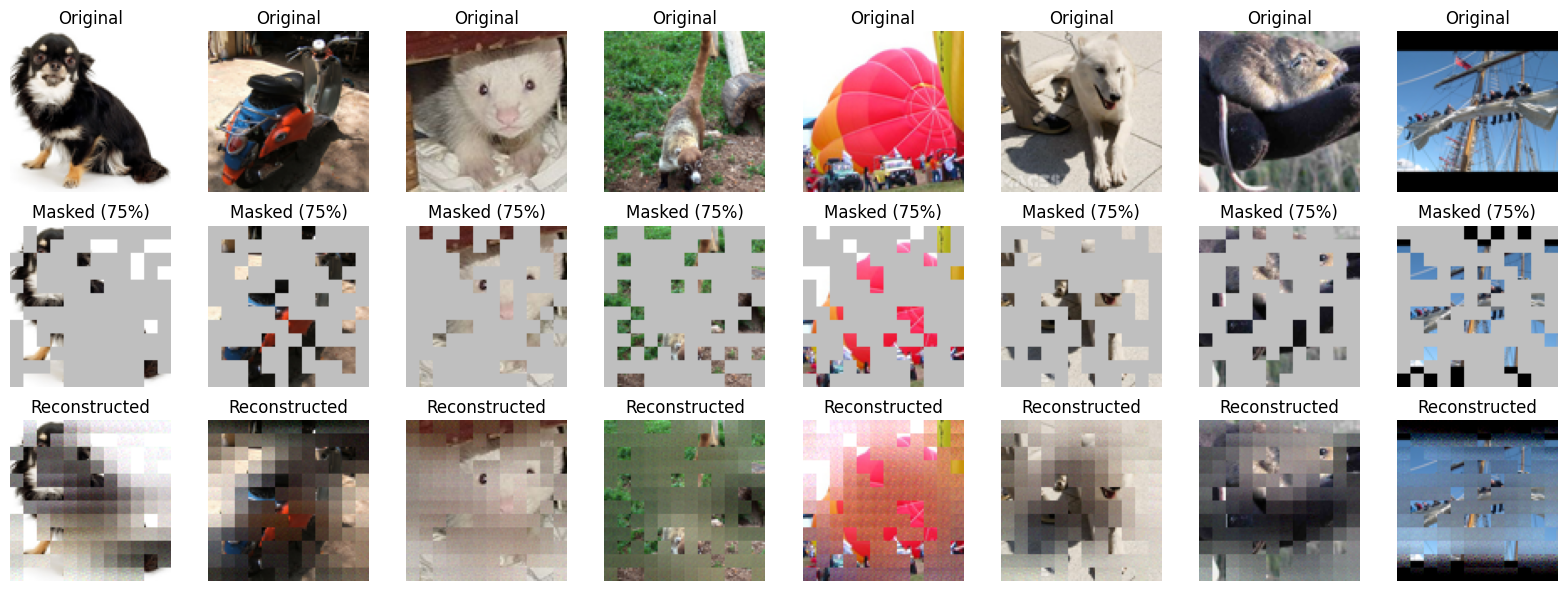


Reconstruction Statistics:
MSE Loss: 0.119023
MAE Loss: 0.226530
PSNR: 9.24 dB


In [11]:
train_loader, val_loader = get_pretrain_dataloaders(cfg)
reconstructor = MAEReconstructor(model=pretrain_model, mask_ratio=cfg["pretrain"]["mask_ratio_end"])
reconstructor.validate_reconstruction(val_loader, num_samples=8)

### Part 9: Fine-tuning the downstream task (image classification) <a class="anchor" id="part_09"></a>
In this part, we will fine-tune the vision classifier model on the downstream image classification task using the STL-10 dataset. We will leverage the representations learned by the MAE during self-supervised pretraining to improve classification performance.

In [12]:
def load_vit_classifier_from_checkpoint(
    model_cfg: dict,
    training_cfg: dict,
    checkpoint_path: str | Path | None = None,
    encoder_only: bool = False,
) -> LightningModule:
    """
    Loads a ViTClassifierTrainModule from either:
        - Lightning checkpoint (.ckpt)
        - Pure PyTorch state_dict (.pt)
        - Encoder-only PyTorch checkpoint (.pt)
    Or returns a randomly initialized model when checkpoint_path=None.

    Args:
        checkpoint_path: path to .ckpt or .pt
        model_cfg, training_cfg: YAML configs
        encoder_only: if True, load only encoder weights

    Returns:
        ViTClassifierTrainModule
    """
    print(f"🔁 Loading ViTClassifierTrainModule from checkpoint: {checkpoint_path}")

    if checkpoint_path is None:
        encoder_cfg = model_cfg["encoder"]
        general = model_cfg["general"]

        encoder = VisionTransformer(
            img_size=general["image_size"],
            patch_size=general["patch_size"],
            in_chans=general["in_chans"],
            embed_dim=encoder_cfg["embed_dim"],
            depth=encoder_cfg["depth"],
            num_heads=encoder_cfg["num_heads"],
            num_classes=0,
        )

        print("🔧 Lightning module ahs been randomly initialized")
        return ViTClassifierTrainModule(
            pretrained_encoder=encoder,
            model_cfg=model_cfg,
            training_cfg=training_cfg,
        )

    checkpoint_path = Path(checkpoint_path)
    is_ckpt = checkpoint_path.suffix == ".ckpt"

    if is_ckpt and not encoder_only:
        print("🔧 Loaded from lightning checkpoint")
        return ViTClassifierTrainModule.load_from_checkpoint(
            checkpoint_path,
            strict=False,
            map_location="cpu",
        )

    ckpt = torch.load(checkpoint_path, map_location="cpu")
    state_dict = ckpt.get("state_dict", ckpt)

    if encoder_only:
        general = model_cfg["general"]
        enc_cfg = model_cfg["encoder"]

        encoder = VisionTransformer(
            img_size=general["image_size"],
            patch_size=general["patch_size"],
            in_chans=general["in_chans"],
            embed_dim=enc_cfg["embed_dim"],
            depth=enc_cfg["depth"],
            num_heads=enc_cfg["num_heads"],
            num_classes=0,  # encoder only
        )

        possible_prefixes = ["model.encoder.", "encoder.", "module.encoder."]

        prefix = next(
            (p for p in possible_prefixes if any(k.startswith(p) for k in state_dict)),
            None,
        )
        if prefix is None:
            raise ValueError(
                "❌ Could not find encoder weights in PT checkpoint. "
                f"Tried prefixes: {possible_prefixes}"
            )

        encoder_state = {
            k[len(prefix) :]: v for k, v in state_dict.items() if k.startswith(prefix)
        }

        missing, unexpected = encoder.load_state_dict(encoder_state, strict=False)

        print(
            f"🔧 Loaded encoder-only weights "
            f"({len(encoder_state)} tensors, {len(missing)} missing, {len(unexpected)} unexpected)"
        )
        return ViTClassifierTrainModule(
            pretrained_encoder=encoder,
            model_cfg=model_cfg,
            training_cfg=training_cfg,
        )

    module = ViTClassifierTrainModule(
        pretrained_encoder=None,
        model_cfg=model_cfg,
        training_cfg=training_cfg,
    )
    module.model.load_state_dict(state_dict, strict=False)

    print("🔧 Loaded full classifier weights")
    return module

In [13]:
has_weights = BEST_CLASSIF_MODEL_PATH.is_file()

if has_weights:
    # Load pretrained classifier weights
    print(f"🔄 Loading classifier weights from: {BEST_CLASSIF_MODEL_PATH}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(BEST_CLASSIF_MODEL_PATH, map_location=device)
    train_cfg = cfg["train"]
    model_cfg = cfg["model"]

    module: ViTClassifierTrainModule = load_vit_classifier_from_checkpoint(
        checkpoint_path=BEST_CLASSIF_MODEL_PATH,
        model_cfg=model_cfg,
        training_cfg=train_cfg,
        encoder_only=False,
    )
    print("✅ Classifier weights loaded successfully.")
else:

    model_cfg = cfg["model"]
    train_cfg = cfg["train"]
    log_cfg = cfg["logging"]

    # ------------------------------
    # Output dirs
    # ------------------------------
    output_dir = Path(log_cfg["output_dir_base"]) / "train" 
    ckpt_dir = output_dir / "checkpoints"
    ckpt_dir.mkdir(parents=True, exist_ok=True)


    # ------------------------------
    # Data
    # ------------------------------
    train_loader, val_loader = get_train_dataloaders(cfg)

    # ------------------------------
    # Model setup
    # ------------------------------
    module: ViTClassifierTrainModule = load_vit_classifier_from_checkpoint(
        checkpoint_path=None,
        model_cfg=model_cfg,
        training_cfg=train_cfg,
        encoder_only=False,
    )

    # Unfreeze encoder if configured
    if train_cfg.get("unfreeze_last_layers", None) is not None:
        module.unfreeze_last_layers(int(train_cfg["unfreeze_last_layers"]))
    elif train_cfg.get("freeze_encoder", True):
        module.freeze_encoder()
    else:
        module.unfreeze_encoder()

    # ------------------------------
    # Logging + Checkpoints
    # ------------------------------
    tb_logger = TensorBoardLogger(save_dir=str(output_dir / "logs"), name="tb")

    ckpt_best = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best",
        save_top_k=1,
        monitor="val_acc",
        mode="max",
        save_last=False,
        verbose=True,
    )
    ckpt_last = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="last",
        save_top_k=1,
        every_n_epochs=1,
        verbose=True,
    )

    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # ------------------------------
    # Trainer
    # ------------------------------
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=train_cfg["total_epochs"],
        logger=tb_logger,
        callbacks=[ckpt_best, ckpt_last, lr_monitor],
        log_every_n_steps=2,
        precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
        gradient_clip_val=1.0,
        gradient_clip_algorithm="norm",
    )

    trainer.fit(module, train_loader, val_loader)

    # ------------------------------
    # Save model + summary
    # ------------------------------
    model_path = output_dir / log_cfg["model_path"]
    torch.save(module.model.state_dict(), model_path)

    print("\n✅ Training complete")
    print(f"📦 Model weights saved to: {model_path}")
    print(f"🏁 Best checkpoint: {ckpt_best.best_model_path}")
    print(f"📈 Logs available at: {tb_logger.log_dir}")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | ViTClassifier | 1.1 M  | train
------------------------------------------------
1.4 K     Trainable params
1.1 M     Non-trainable params
1.1 M     Total params
4.213     Total estimated model params size (MB)
103       Modules in train mode
0         Modules in eval mode


⚙️ Using 400 samples/class → 4000 train, 1000 val
🔁 Loading ViTClassifierTrainModule from checkpoint: None
🔧 Lightning module ahs been randomly initialized
🧊 Encoder frozen (only classifier head is trainable).
🧊 Encoder frozen (only classifier head is trainable).
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 11.52it/s, v_num=2, train_loss=2.460, train_acc=0.118, val_loss=2.500, val_acc=0.101]

Epoch 0, global step 8: 'val_acc' reached 0.10100 (best 0.10100), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 1: 100%|██████████| 8/8 [00:00<00:00,  9.84it/s, v_num=2, train_loss=2.470, train_acc=0.0913, val_loss=2.490, val_acc=0.102]

Epoch 1, global step 16: 'val_acc' reached 0.10200 (best 0.10200), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 2: 100%|██████████| 8/8 [00:00<00:00,  9.71it/s, v_num=2, train_loss=2.440, train_acc=0.130, val_loss=2.480, val_acc=0.100] 

Epoch 2, global step 24: 'val_acc' was not in top 1


Epoch 3: 100%|██████████| 8/8 [00:00<00:00,  9.87it/s, v_num=2, train_loss=2.480, train_acc=0.108, val_loss=2.470, val_acc=0.101] 

Epoch 3, global step 32: 'val_acc' was not in top 1


Epoch 4: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, v_num=2, train_loss=2.410, train_acc=0.123, val_loss=2.450, val_acc=0.102] 

Epoch 4, global step 40: 'val_acc' was not in top 1


Epoch 5: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, v_num=2, train_loss=2.420, train_acc=0.113, val_loss=2.430, val_acc=0.104] 

Epoch 5, global step 48: 'val_acc' reached 0.10400 (best 0.10400), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 6: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s, v_num=2, train_loss=2.390, train_acc=0.103, val_loss=2.410, val_acc=0.103]

Epoch 6, global step 56: 'val_acc' was not in top 1


Epoch 7: 100%|██████████| 8/8 [00:00<00:00,  9.65it/s, v_num=2, train_loss=2.350, train_acc=0.108, val_loss=2.390, val_acc=0.104] 

Epoch 7, global step 64: 'val_acc' reached 0.10400 (best 0.10400), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 8: 100%|██████████| 8/8 [00:00<00:00,  9.68it/s, v_num=2, train_loss=2.360, train_acc=0.108, val_loss=2.360, val_acc=0.109] 

Epoch 8, global step 72: 'val_acc' reached 0.10900 (best 0.10900), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 9: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, v_num=2, train_loss=2.340, train_acc=0.106, val_loss=2.340, val_acc=0.113] 

Epoch 9, global step 80: 'val_acc' reached 0.11300 (best 0.11300), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 10: 100%|██████████| 8/8 [00:00<00:00,  9.72it/s, v_num=2, train_loss=2.280, train_acc=0.149, val_loss=2.320, val_acc=0.120] 

Epoch 10, global step 88: 'val_acc' reached 0.12000 (best 0.12000), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 11: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s, v_num=2, train_loss=2.270, train_acc=0.135, val_loss=2.300, val_acc=0.133] 

Epoch 11, global step 96: 'val_acc' reached 0.13300 (best 0.13300), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 12: 100%|██████████| 8/8 [00:00<00:00,  9.67it/s, v_num=2, train_loss=2.270, train_acc=0.123, val_loss=2.280, val_acc=0.141]

Epoch 12, global step 104: 'val_acc' reached 0.14100 (best 0.14100), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 13: 100%|██████████| 8/8 [00:00<00:00,  9.69it/s, v_num=2, train_loss=2.250, train_acc=0.139, val_loss=2.260, val_acc=0.151]

Epoch 13, global step 112: 'val_acc' reached 0.15100 (best 0.15100), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 14: 100%|██████████| 8/8 [00:00<00:00,  9.43it/s, v_num=2, train_loss=2.220, train_acc=0.149, val_loss=2.250, val_acc=0.158]

Epoch 14, global step 120: 'val_acc' reached 0.15800 (best 0.15800), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 15: 100%|██████████| 8/8 [00:00<00:00,  9.61it/s, v_num=2, train_loss=2.210, train_acc=0.204, val_loss=2.230, val_acc=0.164]

Epoch 15, global step 128: 'val_acc' reached 0.16400 (best 0.16400), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 16: 100%|██████████| 8/8 [00:00<00:00,  9.62it/s, v_num=2, train_loss=2.230, train_acc=0.163, val_loss=2.220, val_acc=0.177]

Epoch 16, global step 136: 'val_acc' reached 0.17700 (best 0.17700), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 17: 100%|██████████| 8/8 [00:00<00:00,  9.62it/s, v_num=2, train_loss=2.180, train_acc=0.183, val_loss=2.210, val_acc=0.182]

Epoch 17, global step 144: 'val_acc' reached 0.18200 (best 0.18200), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 18: 100%|██████████| 8/8 [00:00<00:00,  9.74it/s, v_num=2, train_loss=2.180, train_acc=0.175, val_loss=2.200, val_acc=0.189]

Epoch 18, global step 152: 'val_acc' reached 0.18900 (best 0.18900), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 19: 100%|██████████| 8/8 [00:00<00:00,  9.27it/s, v_num=2, train_loss=2.180, train_acc=0.195, val_loss=2.190, val_acc=0.192]

Epoch 19, global step 160: 'val_acc' reached 0.19200 (best 0.19200), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 20: 100%|██████████| 8/8 [00:00<00:00,  9.66it/s, v_num=2, train_loss=2.150, train_acc=0.204, val_loss=2.180, val_acc=0.198]

Epoch 20, global step 168: 'val_acc' reached 0.19800 (best 0.19800), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 21: 100%|██████████| 8/8 [00:00<00:00,  9.54it/s, v_num=2, train_loss=2.150, train_acc=0.221, val_loss=2.180, val_acc=0.197]

Epoch 21, global step 176: 'val_acc' was not in top 1


Epoch 22: 100%|██████████| 8/8 [00:00<00:00,  9.64it/s, v_num=2, train_loss=2.160, train_acc=0.200, val_loss=2.170, val_acc=0.204]

Epoch 22, global step 184: 'val_acc' reached 0.20400 (best 0.20400), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 23: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, v_num=2, train_loss=2.180, train_acc=0.180, val_loss=2.170, val_acc=0.208]

Epoch 23, global step 192: 'val_acc' reached 0.20800 (best 0.20800), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 24: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, v_num=2, train_loss=2.150, train_acc=0.200, val_loss=2.160, val_acc=0.208]

Epoch 24, global step 200: 'val_acc' was not in top 1


Epoch 25: 100%|██████████| 8/8 [00:00<00:00,  9.72it/s, v_num=2, train_loss=2.160, train_acc=0.161, val_loss=2.160, val_acc=0.210]

Epoch 25, global step 208: 'val_acc' reached 0.21000 (best 0.21000), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 26: 100%|██████████| 8/8 [00:00<00:00,  9.45it/s, v_num=2, train_loss=2.130, train_acc=0.219, val_loss=2.150, val_acc=0.214]

Epoch 26, global step 216: 'val_acc' reached 0.21400 (best 0.21400), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 27: 100%|██████████| 8/8 [00:00<00:00,  9.79it/s, v_num=2, train_loss=2.140, train_acc=0.197, val_loss=2.150, val_acc=0.214]

Epoch 27, global step 224: 'val_acc' was not in top 1


Epoch 28: 100%|██████████| 8/8 [00:00<00:00,  9.41it/s, v_num=2, train_loss=2.110, train_acc=0.240, val_loss=2.150, val_acc=0.218]

Epoch 28, global step 232: 'val_acc' reached 0.21800 (best 0.21800), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 29: 100%|██████████| 8/8 [00:00<00:00,  9.70it/s, v_num=2, train_loss=2.130, train_acc=0.219, val_loss=2.140, val_acc=0.219]

Epoch 29, global step 240: 'val_acc' reached 0.21900 (best 0.21900), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 30: 100%|██████████| 8/8 [00:00<00:00,  9.47it/s, v_num=2, train_loss=2.160, train_acc=0.195, val_loss=2.140, val_acc=0.220]

Epoch 30, global step 248: 'val_acc' reached 0.22000 (best 0.22000), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 31: 100%|██████████| 8/8 [00:00<00:00,  9.33it/s, v_num=2, train_loss=2.130, train_acc=0.221, val_loss=2.140, val_acc=0.221]

Epoch 31, global step 256: 'val_acc' reached 0.22100 (best 0.22100), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 32: 100%|██████████| 8/8 [00:00<00:00,  9.28it/s, v_num=2, train_loss=2.140, train_acc=0.195, val_loss=2.140, val_acc=0.222]

Epoch 32, global step 264: 'val_acc' reached 0.22200 (best 0.22200), saving model to '/home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt' as top 1


Epoch 33: 100%|██████████| 8/8 [00:00<00:00,  9.61it/s, v_num=2, train_loss=2.120, train_acc=0.212, val_loss=2.140, val_acc=0.221]

Epoch 33, global step 272: 'val_acc' was not in top 1


Epoch 34: 100%|██████████| 8/8 [00:00<00:00,  9.38it/s, v_num=2, train_loss=2.130, train_acc=0.212, val_loss=2.130, val_acc=0.220]

Epoch 34, global step 280: 'val_acc' was not in top 1


Epoch 35: 100%|██████████| 8/8 [00:00<00:00,  9.51it/s, v_num=2, train_loss=2.130, train_acc=0.212, val_loss=2.130, val_acc=0.220]

Epoch 35, global step 288: 'val_acc' was not in top 1


Epoch 36: 100%|██████████| 8/8 [00:00<00:00,  9.36it/s, v_num=2, train_loss=2.140, train_acc=0.212, val_loss=2.130, val_acc=0.220]

Epoch 36, global step 296: 'val_acc' was not in top 1


Epoch 37: 100%|██████████| 8/8 [00:00<00:00,  9.21it/s, v_num=2, train_loss=2.130, train_acc=0.221, val_loss=2.130, val_acc=0.220]

Epoch 37, global step 304: 'val_acc' was not in top 1


Epoch 38: 100%|██████████| 8/8 [00:00<00:00,  9.38it/s, v_num=2, train_loss=2.110, train_acc=0.219, val_loss=2.130, val_acc=0.220]

Epoch 38, global step 312: 'val_acc' was not in top 1


Epoch 39: 100%|██████████| 8/8 [00:00<00:00,  9.62it/s, v_num=2, train_loss=2.120, train_acc=0.214, val_loss=2.130, val_acc=0.221]

Epoch 39, global step 320: 'val_acc' was not in top 1


Epoch 40: 100%|██████████| 8/8 [00:00<00:00,  9.21it/s, v_num=2, train_loss=2.110, train_acc=0.207, val_loss=2.130, val_acc=0.222]

Epoch 40, global step 328: 'val_acc' was not in top 1


Epoch 41: 100%|██████████| 8/8 [00:00<00:00,  9.41it/s, v_num=2, train_loss=2.110, train_acc=0.233, val_loss=2.130, val_acc=0.222]

Epoch 41, global step 336: 'val_acc' was not in top 1


Epoch 42: 100%|██████████| 8/8 [00:00<00:00,  9.22it/s, v_num=2, train_loss=2.110, train_acc=0.197, val_loss=2.130, val_acc=0.222]

Epoch 42, global step 344: 'val_acc' was not in top 1


Epoch 43: 100%|██████████| 8/8 [00:00<00:00,  9.56it/s, v_num=2, train_loss=2.110, train_acc=0.226, val_loss=2.130, val_acc=0.222]

Epoch 43, global step 352: 'val_acc' was not in top 1


Epoch 44: 100%|██████████| 8/8 [00:00<00:00,  8.96it/s, v_num=2, train_loss=2.120, train_acc=0.224, val_loss=2.130, val_acc=0.221]

Epoch 44, global step 360: 'val_acc' was not in top 1


Epoch 45: 100%|██████████| 8/8 [00:00<00:00,  9.33it/s, v_num=2, train_loss=2.120, train_acc=0.216, val_loss=2.130, val_acc=0.221]

Epoch 45, global step 368: 'val_acc' was not in top 1


Epoch 46: 100%|██████████| 8/8 [00:00<00:00,  9.47it/s, v_num=2, train_loss=2.140, train_acc=0.180, val_loss=2.130, val_acc=0.222]

Epoch 46, global step 376: 'val_acc' was not in top 1


Epoch 47: 100%|██████████| 8/8 [00:00<00:00,  9.65it/s, v_num=2, train_loss=2.150, train_acc=0.185, val_loss=2.130, val_acc=0.222]

Epoch 47, global step 384: 'val_acc' was not in top 1


Epoch 48: 100%|██████████| 8/8 [00:00<00:00,  9.29it/s, v_num=2, train_loss=2.120, train_acc=0.192, val_loss=2.130, val_acc=0.222]

Epoch 48, global step 392: 'val_acc' was not in top 1


Epoch 49: 100%|██████████| 8/8 [00:00<00:00,  9.60it/s, v_num=2, train_loss=2.150, train_acc=0.240, val_loss=2.130, val_acc=0.222]

Epoch 49, global step 400: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00,  9.45it/s, v_num=2, train_loss=2.150, train_acc=0.240, val_loss=2.130, val_acc=0.222]

✅ Training complete
📦 Model weights saved to: outputs/train/vit-mae.pt
🏁 Best checkpoint: /home/y118982@rsrch.cepetro.unicamp.br/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/outputs/train/checkpoints/best-v2.ckpt
📈 Logs available at: outputs/train/logs/tb/version_2


### Part 10: Evaluating the downstream task<a class="anchor" id="part_10"></a>
In this part, we will evaluate the performance of the fine-tuned vision classifier model on the downstream image classification task using the STL-10 dataset. We will compute metrics such as accuracy to assess how well the model performs on unseen data.

In [14]:
def evaluate_test_set(cfg):
     # Dictionary to store results: {pretrain_pct: {labels_per_class: accuracy}}
    results = {}
    weights_dir = Path("assets") / "weights"

    if not weights_dir.exists():
        print(f"Error: weights file does not exist. You should download the weights first to visualize the results. \n"
          "Run '!bash download_weights.sh' in a python cell before executing this code. ")
        return
    test_loader = get_test_dataloader(cfg)
    # Scan all checkpoint files
    for ckpt_file in weights_dir.glob("mae_*.pt"):
        pretrain_pct, labels_per_class = parse_filename(ckpt_file.name)

        if pretrain_pct is not None and labels_per_class is not None:
            accuracy = evaluate_checkpoint(cfg, ckpt_file, test_loader)

            if accuracy is not None:
                if pretrain_pct not in results:
                    results[pretrain_pct] = {}
                results[pretrain_pct][labels_per_class] = accuracy
                print(
                    f"Found: {pretrain_pct}% pretrain, {labels_per_class} labels/class -> {accuracy:.3f} accuracy"
                )

    if not results:
        print("No valid checkpoint files found or no accuracy data extracted")
        return
    return results

def evaluate_checkpoint(cfg: dict, checkpoint_path: str | Path, test_loader: DataLoader | None = None) -> float | None:
    """
    Reusable evaluation helper.
    Loads model, loads test dataloader, runs evaluation, returns test accuracy.
    """
    test_cfg = cfg["test"]
    log_cfg = cfg["logging"]

    # ------------------------------
    # Load model
    # ------------------------------
    module = load_vit_classifier_from_checkpoint(
        checkpoint_path=checkpoint_path,
        model_cfg=cfg["model"],
        training_cfg=cfg["train"],
        encoder_only=False,
    )

    # ------------------------------
    # Logging
    # ------------------------------
    output_dir = (
        Path(log_cfg["output_dir_base"])
        / "test"
        / test_cfg.get("output_dir_suffix", "default")
    )
    output_dir.mkdir(parents=True, exist_ok=True)

    tb_logger = TensorBoardLogger(save_dir=str(output_dir / "logs"), name="tb")

    # ------------------------------
    # Trainer
    # ------------------------------
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        logger=tb_logger,
        precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
    )

    # ------------------------------
    # Test
    # ------------------------------
    print("\n🚀 Starting evaluation...")
    results = trainer.test(module, test_loader, ckpt_path=None)
    acc = results[0].get("test_acc", None)
    print(f"🔎 Test Accuracy: {acc}")

    return acc


def parse_filename(filename):
    """Parse filename to extract pretrain percentage and labels per class."""
    # Extract numbers from filename like mae_100_400.ckpt
    match = re.match(r"mae_(\d+)_(\d+)\.pt", filename)
    if match:
        pretrain_pct = int(match.group(1))
        labels_per_class = int(match.group(2))
        return pretrain_pct, labels_per_class
    return None, None


In [15]:
def create_accuracy_plot(results: dict[int, dict[int, float]]):
    """Create a plot showing accuracy vs labels per class for different pretrain percentages."""
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Define colors and markers for different pretrain percentages
    colors = ["blue", "red", "green", "orange", "black"]
    markers = ["o", "s", "^", "D", "v"]

    pretrain_percentages = sorted(results.keys())

    for i, pretrain_pct in enumerate(pretrain_percentages):
        labels_per_class_list = sorted(results[pretrain_pct].keys())
        accuracies = [results[pretrain_pct][lpc] for lpc in labels_per_class_list]

        plt.plot(
            labels_per_class_list,
            accuracies,
            marker=markers[i % len(markers)],
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=8,
            label=f"{pretrain_pct}% pretraining data",
        )

    plt.xlabel("Labels per Class", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.title(
        "Model Accuracy vs Labels per Class\nfor Different Pretraining Data Amounts",
        fontsize=14,
    )
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Format y-axis as percentage if needed
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda y, _: f"{y:.1%}" if y <= 1 else f"{y:.1f}")
    )

    plt.tight_layout()

    # Save the plot
    output_path = "assets/visualizations/test_accuracy_comparison_plot.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"\nPlot saved to: {output_path}")


In [16]:
results = evaluate_test_set(cfg)

Error: weights file does not exist. You should download the weights first to visualize the results. 
Run '!bash download_weights.sh' in a python cell before executing this code. 


In [17]:
if results:
    create_accuracy_plot(results)
else:
    print("No results to plot.")

No results to plot.


### Part 11: Visualizing UMAP class representations <a class="anchor" id="part_11"></a>
In this part, we will visualize the class representations learned by the vision classifier model using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us visualize high-dimensional data in a lower-dimensional space, allowing us to observe the clustering of different classes based on their learned representations.

In [18]:
def load_encoder_from_ckpt(ckpt_path, model_cfg):
    print(f"🔍 Loading encoder from: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt.get("state_dict", ckpt)

    encoder_cfg = model_cfg["encoder"]
    general_cfg = model_cfg["general"]

    encoder = VisionTransformer(
        img_size=general_cfg["image_size"],
        patch_size=general_cfg["patch_size"],
        in_chans=general_cfg["in_chans"],
        embed_dim=encoder_cfg["embed_dim"],
        depth=encoder_cfg["depth"],
        num_heads=encoder_cfg["num_heads"],
        num_classes=0,
    )

    # Possible prefixes where encoder weights may live
    possible_prefixes = [
        "model.encoder.",  # LightningModule → self.model.encoder
        "encoder.",  # plain state_dict from MAE
        "module.encoder.",  # DDP/DataParallel
    ]

    # Detect which prefix exists in this checkpoint
    prefix = None
    for p in possible_prefixes:
        if any(k.startswith(p) for k in state_dict.keys()):
            prefix = p
            break

    if prefix is None:
        raise ValueError(
            "❌ Could not find encoder weights in checkpoint. "
            "Expected keys starting with one of: " + ", ".join(possible_prefixes)
        )

    print(f"🔎 Detected encoder prefix in checkpoint: '{prefix}'")

    # Extract only encoder weights and strip the prefix
    encoder_state = {
        k[len(prefix) :]: v for k, v in state_dict.items() if k.startswith(prefix)
    }

    missing, unexpected = encoder.load_state_dict(encoder_state, strict=False)
    print(f"   → Loaded {len(encoder_state)} params")
    print(f"   → Missing: {len(missing)} | Unexpected: {len(unexpected)}")

    return encoder


# --------------------------------------------------
# Feature extraction with cls/mean pooling
# --------------------------------------------------
def pool_features(out, method):
    """
    out shape: (B, N, D)
    """
    if method == "cls":
        return out[:, 0, :]  # CLS token
    elif method == "mean":
        return out[:, 1:, :].mean(dim=1)  # average patch tokens
    else:
        raise ValueError(f"Unknown pool method: {method}")


def apply_normalization(features, mode):
    """
    features: numpy array (N, D)
    """
    if mode == "none":
        return features

    if mode == "l2":
        norm = np.linalg.norm(features, axis=1, keepdims=True) + 1e-8
        return features / norm

    if mode == "channel":
        mean = features.mean(axis=0, keepdims=True)
        std = features.std(axis=0, keepdims=True) + 1e-8
        return (features - mean) / std

    raise ValueError(f"Unknown normalization mode: {mode}")


@torch.no_grad()
def extract_features(
    encoder,
    dataloader,
    device,
    max_samples,
    pool_method,
    norm_method,
):
    encoder.eval()
    feats = []
    labels = []

    for imgs, lbls in dataloader:
        imgs = imgs.to(device)

        out = encoder.forward_features(imgs)
        pooled = pool_features(out, pool_method)

        feats.append(pooled.cpu())
        labels.append(lbls)

        if sum(len(x) for x in labels) >= max_samples:
            break

    feats = torch.cat(feats, dim=0)[:max_samples]
    labels = torch.cat(labels, dim=0)[:max_samples]

    # normalization step
    feats = feats.numpy()
    feats = apply_normalization(feats, norm_method)

    return feats, labels.numpy()


# --------------------------------------------------
# Dimensionality reduction
# --------------------------------------------------
def project(features, method="umap"):
    if method == "tsne":
        print("🔎 Running t-SNE...")
        tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto")
        return tsne.fit_transform(features)

    elif method == "umap":
        print("🔎 Running UMAP...")
        reducer = umap.UMAP(n_components=2)
        return reducer.fit_transform(features)

    raise ValueError(f"Unknown method: {method}")


# --------------------------------------------------
# Plot
# --------------------------------------------------
def plot_embedding(Z, y, out_path, title_extra, class_names):
    plt.figure(figsize=(8, 8))

    # unique sorted classes
    classes = np.unique(y)

    for cls in classes:
        mask = y == cls
        plt.scatter(
            Z[mask, 0],
            Z[mask, 1],
            s=12,
            label=class_names[cls],
        )

    plt.title(f"2D feature projection ({title_extra})")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"📁 Saved figure to {out_path}")


def plot_class_vs_all(Z, y, class_id, class_name, out_path):
    plt.figure(figsize=(6, 6))

    # Background classes (gray)
    mask_bg = y != class_id
    plt.scatter(Z[mask_bg, 0], Z[mask_bg, 1], c="lightgray", s=10, label="other")

    # Highlight class_id
    mask_cls = y == class_id
    plt.scatter(
        Z[mask_cls, 0],
        Z[mask_cls, 1],
        c="tab:red",
        s=12,
        label=class_name,
    )

    plt.title(f"Class {class_name} vs all")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()


In [19]:
model_cfg = cfg["model"]
method = "umap" # "umap" or "tsne"
pool = "cls"  # "cls" or "mean"
normalize = "l2"  # "none", "l2", "channel"
max_samples = 2000

device = "cuda" if torch.cuda.is_available() else "cpu"
if not BEST_CLASSIF_MODEL_PATH.is_file():
    print(f"Error: weights file does not exist. You should download the weights first to visualize the results. \n"
          "Run '!bash download_weights.sh' in a python cell before executing this code. ")
else:
    encoder = load_encoder_from_ckpt(BEST_CLASSIF_MODEL_PATH, model_cfg).to(device)

    dataloader = get_test_dataloader(cfg)
    class_names = dataloader.dataset.classes

    print("📥 Extracting features…")
    feats, labels = extract_features(
        encoder,
        dataloader,
        device,
        max_samples,
        pool,
        normalize,
    )

    print("📉 Projecting to 2D…")
    Z = project(feats, method=method)

    save_dir = Path("assets") / "visualizations"
    save_dir.mkdir(exist_ok=True)
    ckpt_name = Path(BEST_CLASSIF_MODEL_PATH).parent.parent.stem

    out_path = (
        save_dir
        / f"representation_{ckpt_name}_{method}_{pool}_{normalize}.png"
    )
    title_info = f"{method}, pool={pool}, norm={normalize}"
    plot_embedding(Z, labels, str(out_path), title_info, class_names)
    # Generate 10 class-vs-all plots
    for cls_id in np.unique(labels):
        class_name = class_names[cls_id]
        out_path = (
            save_dir
            / f"representation_{ckpt_name}_{method}_{pool}_{normalize}.png"
        )
        out_cls = (
            save_dir
            / f"representation_{ckpt_name}_{method}_{pool}_{normalize}_class{cls_id}.png"
        )
        plot_class_vs_all(Z, labels, cls_id, class_name, str(out_cls))


Error: weights file does not exist. You should download the weights first to visualize the results. 
Run '!bash download_weights.sh' in a python cell before executing this code. 
